In [1]:
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [2]:
from google.colab import files
uploaded = files.upload()


Saving train.csv to train.csv


### Loading dataset

In [3]:
import pandas as pd
data = pd.read_csv('train.csv', encoding='latin-1')
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


### Cleaning dataset

In [5]:
# Keep only the 'Text' and 'Sentiment' columns
data = data[['text', 'sentiment']]
data.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


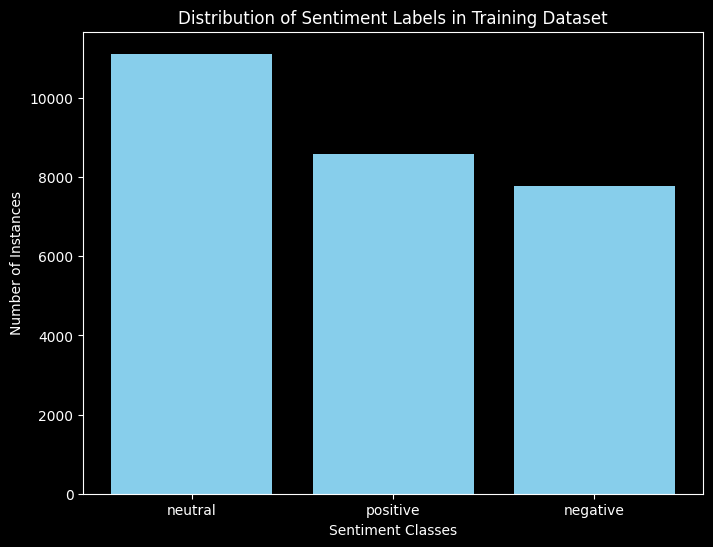

In [7]:
import matplotlib.pyplot as plt

label_count = data['sentiment'].value_counts().to_dict()
plt.style.use("dark_background")
plt.figure(figsize=(8, 6))
plt.bar(label_count.keys(), label_count.values(), color='skyblue')
plt.xlabel('Sentiment Classes')
plt.ylabel('Number of Instances')
plt.title('Distribution of Sentiment Labels in Training Dataset')
plt.show()

In [9]:

label_map = {'neutral': 0, 'positive': 1,'negative':2}
data['label'] = data['sentiment'].map(label_map)


### Splitting dataset

In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
device = torch.device("cuda")
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['sentiment'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

<Axes: >

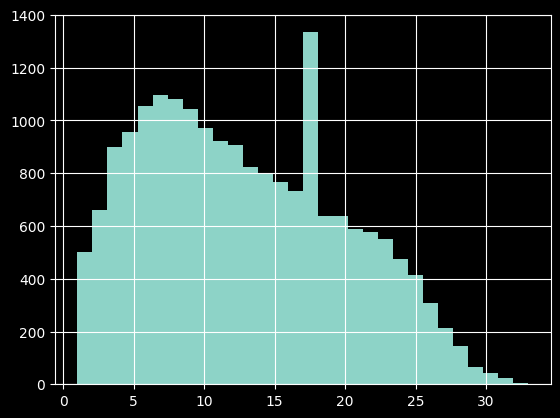

In [11]:

bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [16]:
data.isnull().sum()

,0
text,0
sentiment,0
label,0


In [15]:
data['text'] = data['text'].fillna('').astype(str)


### Training model

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)  # Ensure correct dtype
        }

# Prepare data
train_text, temp_text, train_labels, temp_labels = train_test_split(data['text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['label'])

val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Example maximum length
max_length = 128

# Prepare DataLoader
train_dataset = TextDataset(train_text.tolist(), train_labels.tolist(), tokenizer, max_length)
val_dataset = TextDataset(val_text.tolist(), val_labels.tolist(), tokenizer, max_length)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [31]:
import pandas as pd

# Load dataset
data = pd.read_csv('train.csv', encoding='latin-1')
data = data[['text', 'sentiment']]

# Map sentiment to numerical labels
label_map = {'neutral': 0, 'positive': 1, 'negative': 2}
data['label'] = data['sentiment'].map(label_map)

# Drop the 'sentiment' column
data = data[['text', 'label']]

# Verify label types
print(data.dtypes)


text     object
label     int64
dtype: object


In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

optimizer = Adam(model.parameters(), lr=1e-5)
criterion = CrossEntropyLoss()

# Define training and evaluation functions
def train_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def evaluate(model, dataloader, device):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            _, predicted = torch.max(outputs, dim=1)

            preds.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    return classification_report(true_labels, preds, target_names=['neutral', 'positive', 'negative'])

# Training loop
for epoch in range(5):
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}")

    val_report = evaluate(model, val_loader, device)
    print("Validation Report:\n", val_report)


In [30]:
data.head()

,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,2
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",2


In [25]:
data = data.drop(columns=['sentiment'])


In [26]:
data.head()


,text,label
0,"I`d have responded, if I were going",0
1,Sooo SAD I will miss you here in San Diego!!!,2
2,my boss is bullying me...,2
3,what interview! leave me alone,2
4,"Sons of ****, why couldn`t they put them on t...",2


### Fine tuning

In [ ]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert

        self.dropout = nn.Dropout(0.1)

        self.relu =  nn.ReLU()

        self.fc1 = nn.Linear(768,512)

        self.fc2 = nn.Linear(512,2)

        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):


        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        x = self.fc2(x)

        x = self.softmax(x)

        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = BERT_Arch(bert)

model = model.to(device)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

print('Class Weights:', class_weights)


Class Weights: [0.57743559 3.72848948]


In [ ]:

weights= torch.tensor(class_weights,dtype=torch.float)

weights = weights.to(device)

cross_entropy  = nn.NLLLoss(weight=weights)

epochs = 10

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=1e-5)

def train():
    model.train()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(train_dataloader):
        if step % 50 == 0 and not step == 0:
            print(f'  Batch {step:>5,} of {len(train_dataloader):>5,}.')

        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch

        model.zero_grad()
        preds = model(sent_id, mask)
        loss = cross_entropy(preds, labels)

        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = preds.detach().cpu().numpy()
        total_preds.append(preds)

    avg_loss = total_loss / len(train_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Evaluating Model

In [ ]:
def evaluate():
    print("\nEvaluating...")

    model.eval()
    total_loss = 0
    total_preds = []

    for step, batch in enumerate(val_dataloader):
        if step % 50 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print(f'  Batch {step:>5,} of {len(val_dataloader):>5,}.')

        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch

        with torch.no_grad():
            preds = model(sent_id, mask)
            loss = cross_entropy(preds, labels)

            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

    avg_loss = total_loss / len(val_dataloader)
    total_preds = np.concatenate(total_preds, axis=0)

    return avg_loss, total_preds


  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 1/10
Train Loss: 0.5712, Accuracy: 0.7044
Validation Loss: 0.5455, Accuracy: 0.8122
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 2/10
Train Loss: 0.5493, Accuracy: 0.6921
Validation Loss: 0.5217, Accuracy: 0.8493
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 3/10
Train Loss: 0.5290, Accuracy: 0.6869
Validation Loss: 0.5018, Accuracy: 0.8278
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 4/10
Train Loss: 0.5096, Accuracy: 0.7038
Validation Loss: 0.4836, Accuracy: 0.8337
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 5/10
Train Loss: 0.4958, Accuracy: 0.6887
Validation Loss: 0.4640, Accuracy: 0.8684
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 6/10
Train Loss: 0.4774, Accuracy: 0.7064
Validation Loss: 0.4497, Accuracy: 0.8349
  Batch    50 of   122.
  Batch   100 of   122.

Evaluating...
Epoch 7/10
Train Lo

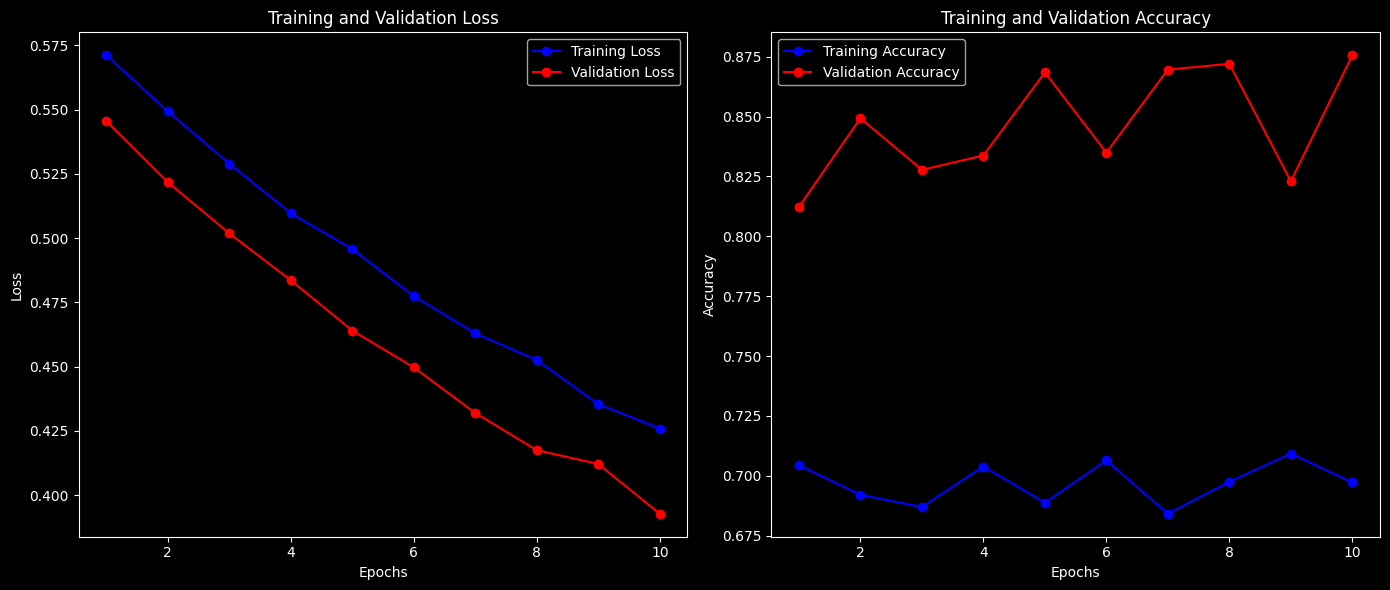

In [ ]:
import matplotlib.pyplot as plt

epochs = 10
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    train_loss, train_preds = train()
    train_losses.append(train_loss)
    val_loss, val_preds = evaluate()
    val_losses.append(val_loss)

    train_accuracy = accuracy_score(train_labels, np.argmax(train_preds, axis=1))
    val_accuracy = accuracy_score(val_labels, np.argmax(val_preds, axis=1))
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{epochs}')
    print(f'Train Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}')
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, 'o-', label='Training Loss', color='blue')
plt.plot(range(1, epochs + 1), val_losses, 'o-', label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_accuracies, 'o-', label='Training Accuracy', color='blue')
plt.plot(range(1, epochs + 1), val_accuracies, 'o-', label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
